In [ ]:
!pip install mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling open

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

In [ ]:
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
NOSE = [1, 197, 5]   # top, bottom, center
MOUTH = [13, 14]     # upper & lower lip
# For mouth we use upper and lower inner lip indices (approx)
MOUTH_UP = 13   # upper lip (approx)
MOUTH_LOW = 14  # lower lip (approx)
# For nose we use top/mid/bottom nose-ish landmarks (these indexes are approximate and may be tuned)
NOSE_TOP = 1
NOSE_BOTTOM = 2
NOSE_CENTER = 5

In [ ]:
# =======================
# Helper Functions
# =======================
def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

In [ ]:
def eye_aspect_ratio_from_points(eye_points):
    # eye_points: list of 6 (x,y) points in order [p1..p6]
    A = euclidean(eye_points[1], eye_points[5])
    B = euclidean(eye_points[2], eye_points[4])
    C = euclidean(eye_points[0], eye_points[3])
    if C == 0:
        return 0.0
    return (A + B) / (2.0 * C)

In [ ]:
def compute_ear(landmarks, frame_w, frame_h):
    left = [(int(landmarks[i].x * frame_w), int(landmarks[i].y * frame_h)) for i in LEFT_EYE]
    right = [(int(landmarks[i].x * frame_w), int(landmarks[i].y * frame_h)) for i in RIGHT_EYE]
    ear_left = eye_aspect_ratio_from_points(left)
    ear_right = eye_aspect_ratio_from_points(right)
    return (ear_left + ear_right) / 2.0, ear_left, ear_right

In [ ]:
def compute_mor(landmarks, frame_w, frame_h):
    # Mouth opening ratio: vertical distance / face height (normalized)
    up = (int(landmarks[MOUTH_UP].x * frame_w), int(landmarks[MOUTH_UP].y * frame_h))
    low = (int(landmarks[MOUTH_LOW].x * frame_w), int(landmarks[MOUTH_LOW].y * frame_h))
    mouth_v = euclidean(up, low)
    # Normalize by face height (approx using bounding box of landmarks)
    ys = [l.y for l in landmarks]
    face_h = (max(ys) - min(ys)) * frame_h
    if face_h == 0:
        return 0.0
    return mouth_v / face_h

In [ ]:
def compute_nlr(landmarks, frame_w, frame_h):
    # Nose length ratio: vertical nose length / face height (normalized)
    top = (int(landmarks[NOSE_TOP].x * frame_w), int(landmarks[NOSE_TOP].y * frame_h))
    bottom = (int(landmarks[NOSE_BOTTOM].x * frame_w), int(landmarks[NOSE_BOTTOM].y * frame_h))
    nose_len = euclidean(top, bottom)
    ys = [l.y for l in landmarks]
    face_h = (max(ys) - min(ys)) * frame_h
    if face_h == 0:
        return 0.0
    return nose_len / face_h

Feature extraction

In [ ]:
VIDEO_PATH =    "/content/Himanshu_New_Dataset.mp4"
CSV_FEATURES = "ear_mor_nlr.csv"
LABELED_CSV = "ear_mor_nlr_labeled.csv"
SEQ_LEN = 30                  # frames per sequence for LSTM
EAR_THRESHOLD = 0.25          # below -> eyes likely closed
MOR_THRESHOLD = 0.045         # above -> mouth open (yawn); normalized measure
NLR_THRESHOLD = 0.02          # below -> nose length ratio small (head tilt) — tune experimentally
LABEL_WINDOW = 10

In [ ]:
import time

def extract_features_from_video(video_path, csv_out):
    print("Extracting features from video:", video_path)
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True,
                                     min_detection_confidence=0.5, min_tracking_confidence=0.5)
    cap = cv2.VideoCapture(video_path)
    rows = []
    frame_idx = 0
    start = time.time()
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        h, w, _ = frame.shape
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = face_mesh.process(rgb)
        if res.multi_face_landmarks:
            lm = res.multi_face_landmarks[0].landmark
            ear, ear_l, ear_r = compute_ear(lm, w, h)
            mor = compute_mor(lm, w, h)
            nlr = compute_nlr(lm, w, h)
            rows.append([frame_idx, ear, ear_l, ear_r, mor, nlr])
        else:
            # Append NaNs if no face detected (you can skip or forward-fill later)
            rows.append([frame_idx, np.nan, np.nan, np.nan, np.nan, np.nan])
        frame_idx += 1
    cap.release()
    face_mesh.close()
    df = pd.DataFrame(rows, columns=["frame", "EAR", "EAR_left", "EAR_right", "MOR", "NLR"])
    df.to_csv(csv_out, index=False)
    elapsed = time.time() - start
    print(f"Saved features to {csv_out} (frames: {len(df)}) in {elapsed:.1f}s")


In [ ]:
extract_features_from_video("/content/Himanshu_New_Dataset.mp4", "features_output.csv")


Extracting features from video: /content/Himanshu_New_Dataset.mp4
Saved features to features_output.csv (frames: 1153) in 8.0s


In [ ]:
# Step B: Labeling (auto by thresholds)
# ---------------------------
def auto_label_csv(csv_in, csv_out, ear_thresh=EAR_THRESHOLD, mor_thresh=MOR_THRESHOLD, nlr_thresh=NLR_THRESHOLD, window=LABEL_WINDOW):
    df = pd.read_csv(csv_in)
    df["label"] = 0
    # create a drowsy flag per frame using thresholds (any condition triggers)
    cond = ((df["EAR"] < ear_thresh) | (df["MOR"] > mor_thresh) | (df["NLR"] < nlr_thresh))
    df["temp_flag"] = cond.astype(int)
    # Use a sliding window to mark segments as drowsy if enough consecutive frames satisfy flag
    for i in range(len(df) - window):
        if df.loc[i:i+window-1, "temp_flag"].sum() >= (window // 2):  # at least half the window true
            df.loc[i:i+window-1, "label"] = 1
    df = df.drop(columns=["temp_flag"])
    df.to_csv(csv_out, index=False)
    print(f"Labeled data saved to {csv_out} (drowsy % = {df['label'].mean()*100:.2f}%)")
    return df

In [ ]:
# Label the raw features
labeled_df = auto_label_csv("/content/features_output.csv",
                            "/content/ear_mor_nlr_labeled.csv",
                            ear_thresh=EAR_THRESHOLD,
                            mor_thresh=MOR_THRESHOLD,
                            nlr_thresh=NLR_THRESHOLD,
                            window=LABEL_WINDOW)


Labeled data saved to /content/ear_mor_nlr_labeled.csv (drowsy % = 73.37%)


Not using the below cell code for sometime


In [ ]:
def create_sequences_from_csv(csv_path="/content/ear_mor_nlr_labeled.csv", seq_len=SEQ_LEN):
    df = pd.read_csv(csv_path)

    # Drop NaNs (rows where no face was detected)
    df = df.dropna().reset_index(drop=True)

    # Extract features and labels
    features = df[["EAR", "MOR", "NLR"]].values
    labels = df["label"].values

    X, y = [], []
    for i in range(len(features) - seq_len):
        X.append(features[i:i+seq_len])
        y.append(labels[i+seq_len-1])  # label of the last frame in sequence

    X = np.array(X)
    y = np.array(y)

    print("Sequences created:", X.shape, y.shape)  # e.g., (num_sequences, seq_len, 3)
    return X, y

In [ ]:
def build_lstm(seq_len=SEQ_LEN, feats=3):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, feats)),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
MODEL_SAVE = "lstm_all_feature_model.h5"   # filename where best model will be saved
BATCH_SIZE = 32                # you can tune this
EPOCHS = 30                    # training epochs
RANDOM_STATE = 42               # for reproducibility


In [ ]:
def train_model(csv_path="/content/ear_mor_nlr_labeled.csv", model_save=MODEL_SAVE, batch_size=BATCH_SIZE, epochs=EPOCHS):
    # Create sequences from labelled CSV
    X, y = create_sequences_from_csv(csv_path)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # Handle class imbalance
    classes = np.unique(y_train)
    class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    print("Class weights:", class_weight_dict)

    model = build_lstm(seq_len=X.shape[1], feats=X.shape[2])
    model.summary()

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ModelCheckpoint(model_save, save_best_only=True, monitor="val_loss")
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=callbacks
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f} | Test Acc: {acc:.4f}")

    # Predictions and classification report
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Save training plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.xlabel('epoch'); plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(); plt.xlabel('epoch'); plt.title('Loss')

    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=200)
    print("Training curves saved to training_curves.png")

    # Confusion matrix heatmap save
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Awake","Drowsy"], yticklabels=["Awake","Drowsy"])
    plt.title("Confusion matrix (test)")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.savefig("confusion_matrix_test.png", dpi=200)
    print("Confusion matrix saved to confusion_matrix_test.png")

    return model, history, (X_test, y_test)

Sequences created: (930, 30, 3) (930,)
Class weights: {0: 3.795918367346939, 1: 0.5758513931888545}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3906 - loss: 0.7154

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4219 - loss: 0.7053 - val_accuracy: 0.8226 - val_loss: 0.4576
Epoch 2/30
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8024 - loss: 0.4440

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7985 - loss: 0.4417 - val_accuracy: 0.7903 - val_loss: 0.4229
Epoch 3/30
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7880 - loss: 0.3909

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7887 - loss: 0.3879 - val_accuracy: 0.8333 - val_loss: 0.3236
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7950 - loss: 0.3373 - val_accuracy: 0.8065 - val_loss: 0.5006
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7848 - loss: 0.3641

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7860 - loss: 0.3624 - val_accuracy: 0.8441 - val_loss: 0.3210
Epoch 6/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8260 - loss: 0.2756

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8239 - loss: 0.2794 - val_accuracy: 0.8387 - val_loss: 0.3133
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8553 - loss: 0.2904 - val_accuracy: 0.8333 - val_loss: 0.3991
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8492 - loss: 0.2580

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8498 - loss: 0.2569 - val_accuracy: 0.8763 - val_loss: 0.2986
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8117 - loss: 0.2786 - val_accuracy: 0.8602 - val_loss: 0.3153
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8724 - loss: 0.2198 - val_accuracy: 0.8387 - val_loss: 0.3819
Epoch 11/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8395 - loss: 0.2392

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8401 - loss: 0.2395 - val_accuracy: 0.8710 - val_loss: 0.2516
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8663 - loss: 0.2030 - val_accuracy: 0.8925 - val_loss: 0.2564
Epoch 13/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8883 - loss: 0.2078 - val_accuracy: 0.8817 - val_loss: 0.2701
Epoch 14/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8704 - loss: 0.1920 - val_accuracy: 0.8978 - val_loss: 0.2761
Epoch 15/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8811 - loss: 0.2222 - val_accuracy: 0.8280 - val_loss: 0.3983
Epoch 16/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8222 - loss: 0.2689 - val_accuracy: 0.8172 - val_loss: 0.3519
Test Loss: 0.2516 | Test Acc: 0.8710

Classification Report:
               precision    recall  f1-score   support

           0     0.5102    1.0000    0.6757        25
           1     1.0000    0.8509    0.9195       161

    accuracy      

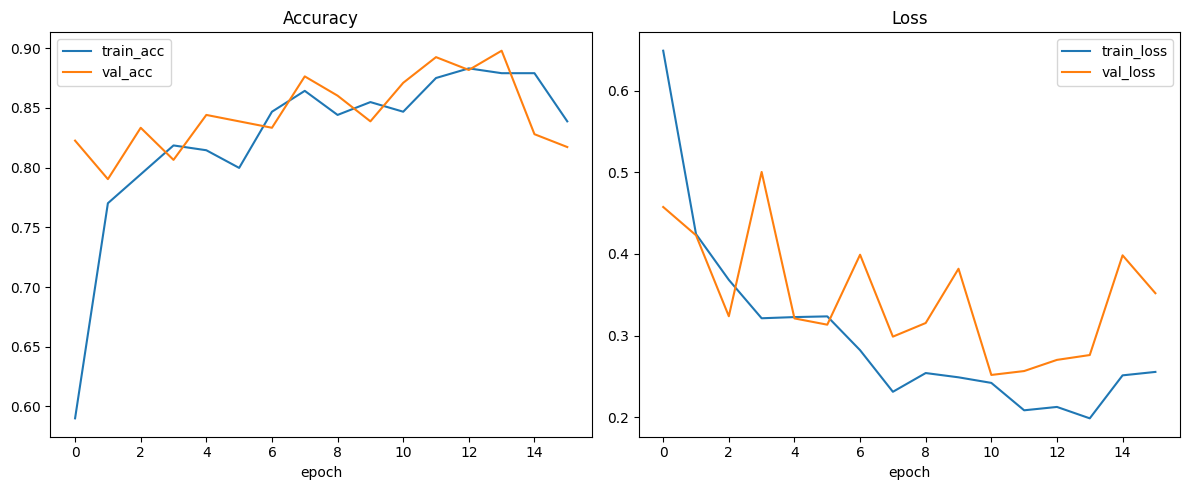

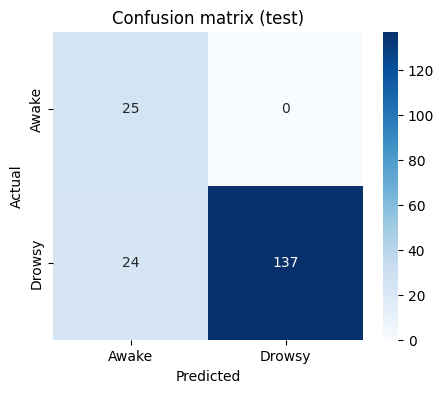

In [ ]:
model, history, test_data = train_model("/content/ear_mor_nlr_labeled.csv")
